The visualization used for this homework is based on Alexandr Verinov's code.  

# Generative models

In this homework we will try several criterions for learning an implicit model. Almost everything is written for you, and you only need to implement the objective for the game and play around with the model. 

**0)** Read the code

**1)** Implement objective for a vanilla [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GAN). The hyperparameters are already set in the code. The model will converge if you implement the objective (1) right. 

**2)** Note the discussion in the paper, that the objective for $G$ can be of two kinds: $min_G log(1 - D)$ and $min_G - log(D)$. Implement the second objective and ensure model converges. Most likely, in this example you will not notice the difference, but people usually use the second objective, it really matters in more complicated scenarios.

**3 & 4)** Implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([WGAN](https://arxiv.org/abs/1704.00028)) and WGAN-GP. To make the discriminator have Lipschitz property you need to clip discriminator's weights to $[-0.01, 0.01]$ range (WGAN) or use gradient penalty (WGAN-GP). You will need to make few modifications to the code: 1) remove sigmoids from discriminator 2) add weight clipping clipping / gradient penaly. 3) change objective. See [implementation 1](https://github.com/martinarjovsky/WassersteinGAN/) / [implementation 2](https://github.com/caogang/wgan-gp). They also use different optimizer. The default hyperparameters may not work, spend time to tune them.

**5) Bonus: same thing without GANs** Implement maximum mean discrepancy estimator (MMD). MMD is discrepancy measure between distributions. In our case we use it to calculate discrepancy between real and fake data. You need to implement RBF kernel $k(x,x')=\exp \left(-{\frac  {1}{2\sigma ^{2}}}||x-x'||^{2}\right)$ and an MMD estimator (see eq.8 from https://arxiv.org/pdf/1505.03906.pdf). MMD is then used instead of discriminator.

In [173]:
""" 
    Please, implement everything in one notebook, using if statements to switch between the tasks
"""
TASK = 5#1  2, 3, 4, 5

# Imports

In [174]:
import numpy as np
import time
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12345)
lims=(-5, 5)

# Define sampler from real data and Z 

In [175]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

In [176]:
def vis_data(data):
    """
        Visualizes data as histogram
    """
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = sample_noise(1000)
def vis_g():
    """
        Visualizes generator's samples as circles
    """
    data = generator(Variable(torch.Tensor(fixed_noise))).data.numpy()
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
def vis_d():
    """
        Visualizes discriminator's gradient on grid
    """
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
    grid = Variable(torch.Tensor(np.vstack([X, Y]).T), requires_grad=True)
    data_gen = generator(Variable(torch.Tensor(fixed_noise)))
    #print("discriminator(data_gen):")
    #print(discriminator(data_gen))
    #print("discriminator(grid):")
    #print(discriminator(grid))
    loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss.backward()
    grads = - grid.grad.data.numpy()
    plt.quiver(X, Y, grads[:, 0], grads[:, 1], color='black',alpha=0.9)

# Define architectures

After you've passed task 1 you can play with architectures.

#### Generator

In [177]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        nn.init.xavier_normal(self.fc1.weight)
        nn.init.constant(self.fc1.bias, 0.0)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal(self.fc2.weight)
        nn.init.constant(self.fc2.bias, 0.0)

        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal(self.fc3.weight)
        nn.init.constant(self.fc3.bias, 0.0)

    def forward(self, z):
        """
            Generator takes a vector of noise and produces sample
        """
        h1 = F.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

#### Discriminator

In [178]:
if TASK == 1 or TASK == 2:
    class Discriminator(nn.Module):
        def __init__(self, in_dim, hidden_dim=100):
            super(Discriminator, self).__init__()

            self.fc1 = nn.Linear(in_dim, hidden_dim)
            nn.init.xavier_normal(self.fc1.weight)
            nn.init.constant(self.fc1.bias, 0.0)

            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            nn.init.xavier_normal(self.fc2.weight)
            nn.init.constant(self.fc2.bias, 0.0)

            self.fc3 = nn.Linear(hidden_dim, hidden_dim)
            nn.init.xavier_normal(self.fc3.weight)
            nn.init.constant(self.fc3.bias, 0.0)

            self.fc4 = nn.Linear(hidden_dim, 1)
            nn.init.xavier_normal(self.fc4.weight)
            nn.init.constant(self.fc4.bias, 0.0)

        def forward(self, x):
            h1 = F.tanh(self.fc1(x))
            h2 = F.leaky_relu(self.fc2(h1))
            h3 = F.leaky_relu(self.fc3(h2))
            score = F.sigmoid(self.fc4(h3))
            return score
if TASK == 3 or TASK == 4:
    class Discriminator(nn.Module):
        def __init__(self, in_dim, hidden_dim=100):
            super(Discriminator, self).__init__()

            self.fc1 = nn.Linear(in_dim, hidden_dim)
            nn.init.xavier_normal(self.fc1.weight)
            nn.init.constant(self.fc1.bias, 0.0)

            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            nn.init.xavier_normal(self.fc2.weight)
            nn.init.constant(self.fc2.bias, 0.0)

            self.fc3 = nn.Linear(hidden_dim, hidden_dim)
            nn.init.xavier_normal(self.fc3.weight)
            nn.init.constant(self.fc3.bias, 0.0)

            self.fc4 = nn.Linear(hidden_dim, 1)
            nn.init.xavier_normal(self.fc4.weight)
            nn.init.constant(self.fc4.bias, 0.0)

        def forward(self, x):
            h1 = F.tanh(self.fc1(x))
            h2 = F.leaky_relu(self.fc2(h1))
            h3 = F.leaky_relu(self.fc3(h2))
            score = self.fc4(h3)
            return score
if TASK == 5:
    def k(x,x1,sigma):
        return torch.exp(-1/2/(sigma*sigma)*(torch.abs(x-x1))**2);
    def MMD(x,x1,y,y1sigma):
        return k(x,x1,sigma) - 2 * k(x,y,sigma) + k(y,y1,sigma);

# Define updates and losses

In [179]:
if TASK == 1 or TASK == 2:
    lr = 0.001
if TASK == 3:
    lr = 0.00005;
if TASK == 4:
    lr = lr=1e-4;
if TASK == 5:
    lr = lr=1e-3;
generator = Generator(NOISE_DIM, out_dim = 2)
if TASK == 1 or TASK == 2 or TASK == 3 or TASK == 4:
    discriminator = Discriminator(in_dim = 2)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))

Notice we are using ADAM optimizer with `beta1=0.5` for both discriminator and discriminator. This is a common practice and works well. Motivation: models should be flexible and adapt itself rapidly to the distributions. 

You can try different optimizers and parameters.

In [180]:
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game
eps = 1e-10;
def g_loss(x):
    if TASK == 1: 
        return torch.mean(torch.log(1-x + eps));
    if TASK == 2:
        return -torch.mean(torch.log(x + eps));
    if TASK == 3:
        return -torch.mean(x);
    if TASK == 4:
        return -torch.mean(x);
    if TASK == 5:
        return -torch.mean(x);
def d_loss(x,y,pen=0):
    if TASK == 1: 
        return -(torch.mean(torch.log(y + eps)) + torch.mean(torch.log(1 - x + eps)));
    if TASK == 2:
        return -(torch.mean(torch.log(y + eps)) + torch.mean(torch.log(1 - x + eps)));
    if TASK == 3:
        return torch.mean(x)-torch.mean(y);
    if TASK == 4:
        return torch.mean(x)-torch.mean(y) + pen;
################################

# Get real data

In [181]:
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in range(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

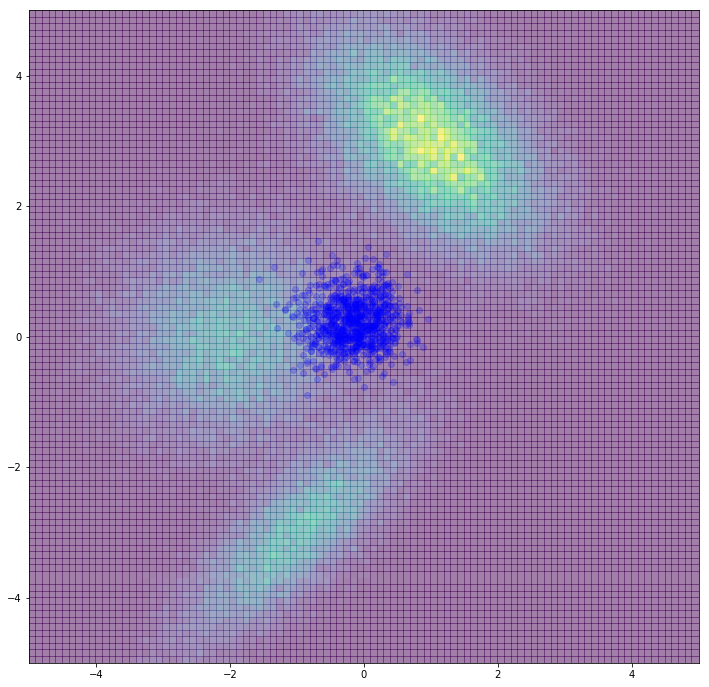

In [182]:
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
if TASK !=5:
    vis_d()

**Legend**:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradients of the discriminator -- they are the directions that discriminator pushes generator's samples. 

# Train the model

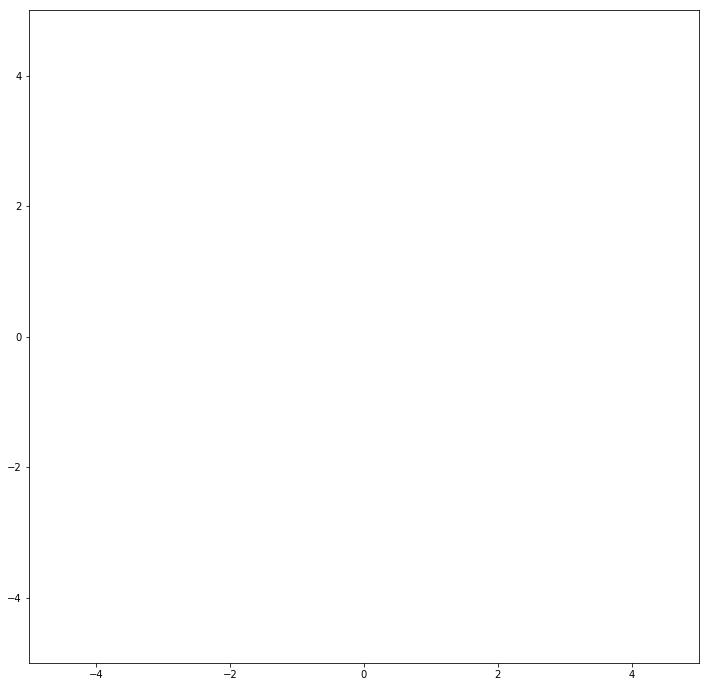

In [183]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64
dweights = 0.01;
sigma = 1;
# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1
LAMBDA = 10;
def calc_gradient_penalty(netD, real_data, fake_data):
    #alpha = torch.rand(batch_size, 1)
    #alpha.unsqueeze_(-1);
    #alpha = alpha.expand(real_data.size())
    alpha = torch.rand(real_data.size());
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


accs = []
if TASK == 1 or TASK == 2:
    try:
        for epoch in range(num_epochs):
            for input_data in iterate_minibatches(data, batch_size):

                # Optimize D
                for _ in range(k_d):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    inp_data = Variable(torch.Tensor(input_data))
                    data_gen = generator(noise)
                    loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                    d_optimizer.zero_grad()
                    loss.backward()
                    d_optimizer.step()

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    data_gen = generator(noise)
                    loss = g_loss(discriminator(data_gen))
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()

                # Visualize
            if epoch == 99:
                plt.clf()
                vis_data(data); vis_g(); vis_d()
                display.clear_output(wait=True)
                display.display(plt.gcf())
    except KeyboardInterrupt:
        pass
if TASK == 3:
    try:
        for epoch in range(num_epochs):
            for input_data in iterate_minibatches(data, batch_size):

                # Optimize D
                for _ in range(k_d):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    inp_data = Variable(torch.Tensor(input_data))
                    data_gen = generator(noise)
                    loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                    d_optimizer.zero_grad()
                    loss.backward()
                    d_optimizer.step()
                    for p in discriminator.parameters():
                        p.data.clamp_(-dweights, dweights); 

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    data_gen = generator(noise)
                    loss = g_loss(discriminator(data_gen))
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()

                # Visualize
            if epoch == 99:
                plt.clf()
                vis_data(data); vis_g(); vis_d()
                display.clear_output(wait=True)
                display.display(plt.gcf())
    except KeyboardInterrupt:
        pass
if TASK == 4:
    try:
        for epoch in tqdm_notebook(range(num_epochs)):
            for input_data in iterate_minibatches(data, batch_size):

                # Optimize D
                for _ in range(k_d):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    inp_data = Variable(torch.Tensor(input_data))
                    data_gen = generator(noise)
                    
                    
                    # train with gradient penalty
                    gradient_penalty = calc_gradient_penalty(discriminator, inp_data.data, data_gen.data);
                    loss = d_loss(discriminator(data_gen), discriminator(inp_data),gradient_penalty);
                    d_optimizer.zero_grad()
                    loss.backward()
                    d_optimizer.step()

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    data_gen = generator(noise)
                    loss = g_loss(discriminator(data_gen))
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()

                # Visualize
            if epoch == 99:
                plt.clf()
                vis_data(data); vis_g(); vis_d()
                display.clear_output(wait=True)
                display.display(plt.gcf())
    except KeyboardInterrupt:
        pass

if TASK == 5:
    try:
        for epoch in range(num_epochs):
            for input_data in iterate_minibatches(data, batch_size):

                # Optimize D
                #for _ in range(k_d):
                #    # Sample noise
                #    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                #    inp_data = Variable(torch.Tensor(input_data))
                #    data_gen = generator(noise)
                    
                    
                    # train with gradient penalty
                #    gradient_penalty = calc_gradient_penalty(discriminator, inp_data.data, data_gen.data);
                #    loss = d_loss(discriminator(data_gen), discriminator(inp_data),gradient_penalty);
                #    d_optimizer.zero_grad()
                #    loss.backward()
                #    d_optimizer.step()

                # Optimize G
                for _ in range(k_g):
                    # Sample noise
                    noise = Variable(torch.Tensor(sample_noise(len(input_data))))

                    # Do an update
                    data_gen = generator(noise)
                    #loss = g_loss(MMD(data_gen[:,0],data_gen[:,1],Variable(torch.FloatTensor(input_data))[:,0],Variable(torch.FloatTensor(input_data))[:,1],sigma))
                    loss = g_loss(k(data_gen,Variable(torch.FloatTensor(input_data)),sigma));
                    g_optimizer.zero_grad()
                    loss.backward()
                    g_optimizer.step()

                # Visualize
            if epoch == 99:
                plt.clf()
                vis_data(data); vis_g(); #vis_d()
                display.clear_output(wait=True)
                display.display(plt.gcf())
    except KeyboardInterrupt:
        pass

# Describe your findings here

Plotted results are:
TASK 1:
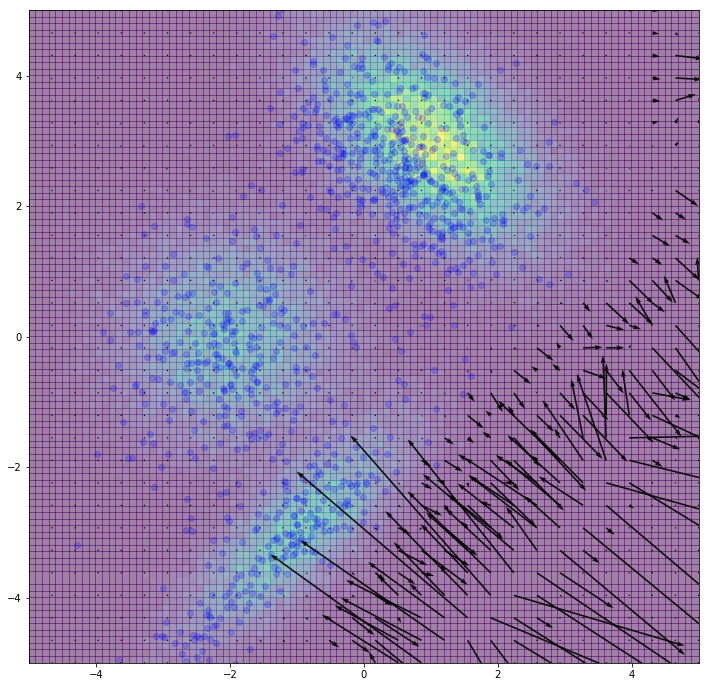
TASK 2:
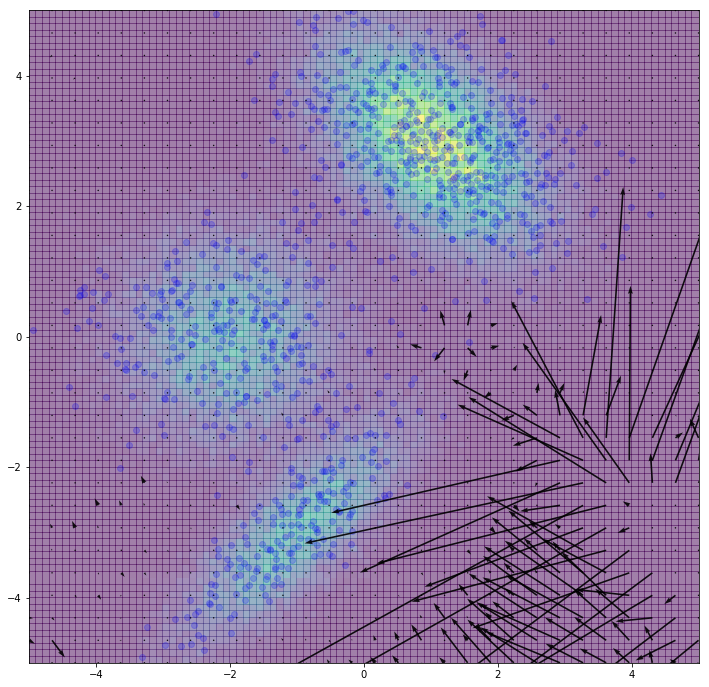
TASK 3:
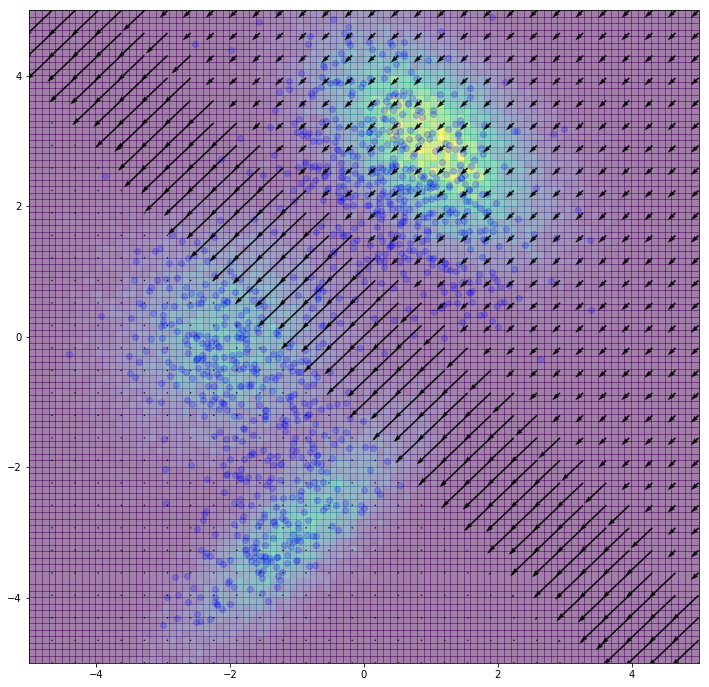
TASK 4:
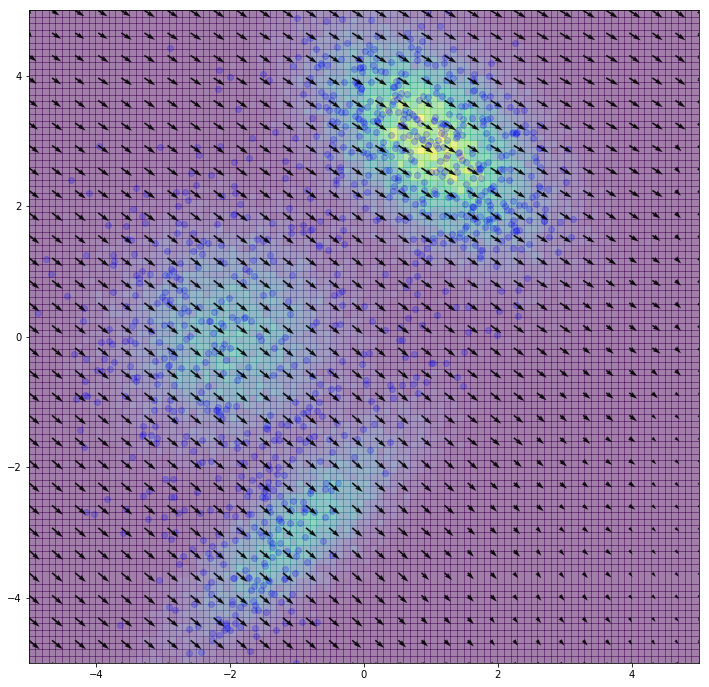
TASK 5:
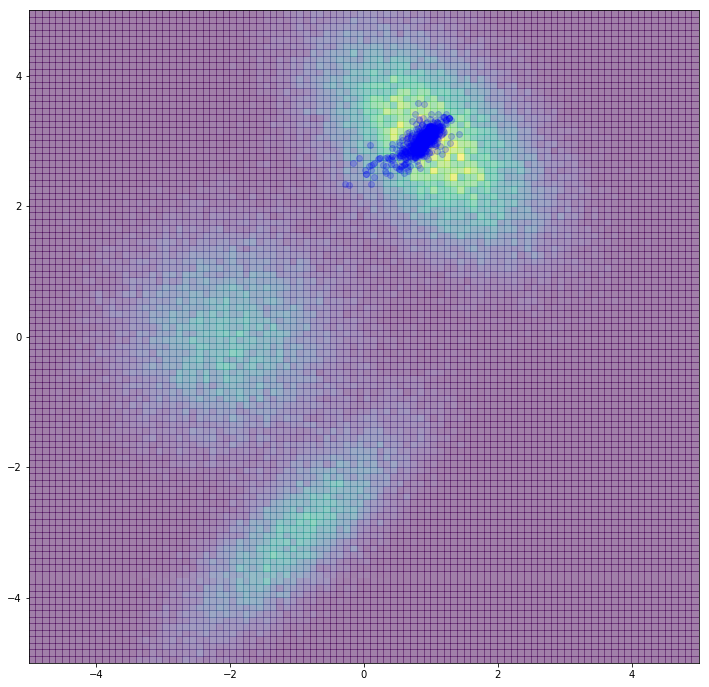

There is pratically no difference between $min_G log(1 - D)$ and $min_G - log(D)$ losses, as it is clear from pictures TASK 1 and TASK 2 above.

For WGAN I observed that weights clamping introduce some random pushes for dots, which helps to achieve denser dots distribution. However, once the minima achieved precise, those techniques start to penalize dense dots accumulations away from their position, so wrap-around errors in convergence arise. That is clear from pictures above. Also calculation complexity increases and each epoch requires more time than in GAN.

Also for WGAN I observed that gradient penalty leads to satisfactory results when dots are in the deep minima, but in other regions they are quite sparse. Overall the result is simillar to GANs.

For MMD all dots went to global minima, fast and precise. Just awesome.